МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Объектами являются пары запрос-документ. Асессоры определяют целевые метки - оценки релевантности пары запрос-документ. Чем такая оценка выше, тем релевантнее документ для запроса. На парах запрос-документ 
введено отношение порядка: если документ $d_1$ релевантнее для запроса q, чем документ $d_2$, то пишут 
$(q, d_1) \triangleright (q, d_2)$. Такой порядок определен только внутри одного запроса.

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

C метрикой NDCG можно использовать вещественные оценки релевантности пар запрос-документ.

**3.** Почему говорят, что все основные метрики качества дискретны?

Наверное, потому что у них дискретные значения - их конечное число.

**4.** В чем преимущество факторизации в модели RankNet?

Градиент при градиентном спуске считается по одной паре запрос-документ.

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

В градиентном спуске разность значений NDCG для двух пар запрос-документ умножается на градиент.

**6.** Какое преобразование данных используется в модели RankSVM?

Из пары ((q, d_i) и y_i) и пары ((q, d_j) и y_j) получается новая пара {(q, d_i) - (q, d_j), sign(y_i - y_j)}.

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

Воспользуемся эргодической теоремой для матрицы переходных вероятностей в квадрате, тогда получаем: $1 - \frac{p^2(n-2)}{(n-1)^2}$

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

По эргодической теореме, предельное распределение единственно, поэтому нет смысла с точки зрения теории брать несколько начальных распределений. С точки зрения практического применения возможно имеет смысл взять несколько начальных распределений и посмотреть на скорость сходимости, затем выбрать то, где быстрее сходится.


# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

Заметим, что каждый элемент матрицы переходных вероятностей $\geq \frac{p}{|V|}$.
Теперь рассмотрим $\pi_i^{(k)}$ - элемент k-го  приближения $\Pi$. Из реккурентной формулы для $\Pi^{(k)}$ имеем: $\pi_i^{(k)} = \sum \limits_{j=1}^{N} p_{ji}\cdot\pi_j^{(k-1)} \geq \frac{p}{|V|} \cdot \sum \limits_{j=1}^{N} \pi_j^{(k-1)} = \frac{p}{|V|}$. Поскольку $\pi_i^{(k)}$ стремится к $\pi_i$, то $\pi_i \geq \frac{p}{|V|}$, что и требовалось.


**3.** Пользователь браузера в дополнение к кликам по ссылкам может перейти по кнопке *Назад* и вернуться на предыдущую страницу? Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

Поскольку у нас есть кнопка назад, то вероятности переходов из конкретной вершины теперь зависят от всех предыдущих переходов (поскольку мы можем много раз нажать назад). Но тогда такая марковская цепь не будет однородной по определению, поэтому ответ нет.

## Часть 1

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from collections import deque

%matplotlib inline
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)
# plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
# plt.rc('font', family='serif', size='16')

Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [2]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''
    out_adj_lists = defaultdict(set)
    links = np.array(links)
    if len(links) == 0:
        return np.zeros((1, 1))
    if N is None:
        N = links.max() + 1
    for start, end in links:
        out_adj_lists[start].add(end)
    prob_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            N_i = len(out_adj_lists[i])
            if N_i == 0:
                prob_matrix[i, j] = 1 / N
            else:
                prob_matrix[i, j] = damping_factor / N
                if j in out_adj_lists[i]:
                    prob_matrix[i, j] += (1 - damping_factor) / N_i
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=1e-7, return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor,
                                                N=start_distribution.shape[1])
    prev_distribution = np.array(start_distribution)
    distribution = prev_distribution.dot(prob_matrix)
    if return_trace:
        trace = [prev_distribution, distribution]
    while np.mean((prev_distribution - distribution) ** 2) > tolerance:
        prev_distribution = distribution
        distribution = prev_distribution.dot(prob_matrix)
        if return_trace:
            trace.append(distribution)
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [3]:
def random_graph(n, p):
    return np.transpose(np.nonzero(np.random.choice([True, False], p=[p, 1-p],
                                                    size=(n, n)).reshape((n, n))))

Теперь сгенерируем случайный граф и нарисуем его.

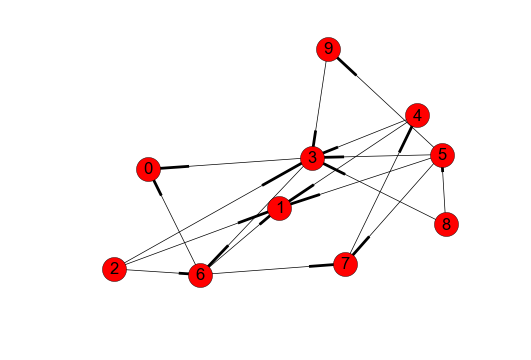

In [4]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_nodes_from(range(N))
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)
# print(edges)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

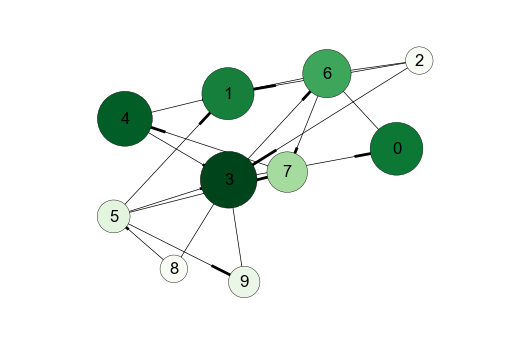

In [5]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 1e4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution, cmap='Greens')

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

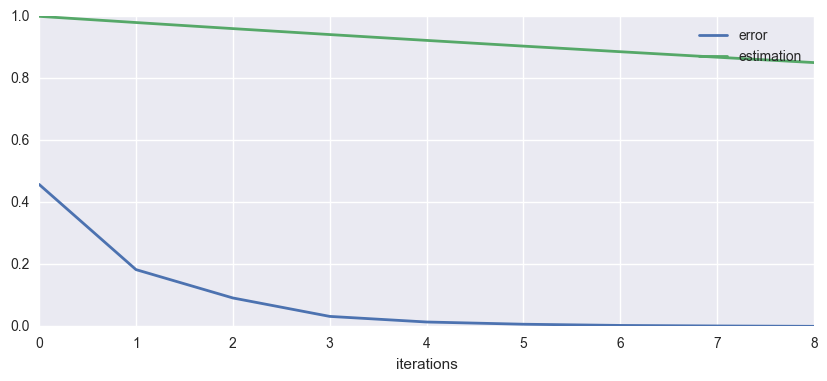

In [6]:
sns.set_style({'axes.grid' : True})
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, (1 - p / N) ** x, 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

Выводы:
Оценка не является точной

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

In [ ]:
ns = np.arange(10, 201, 5)
ps = np.arange(0.05, 1.0, 0.025)
trace_lengths = np.zeros((len(ns), len(ps)))
for idx_n, n in enumerate(ns):
    for idx_p, p in enumerate(ps):
        edges = random_graph(n, p)
        start_distribution = np.ones((1, n)) / n
        pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                              return_trace=True)
        trace_lengths[idx_n, idx_p] = len(pr_trace)

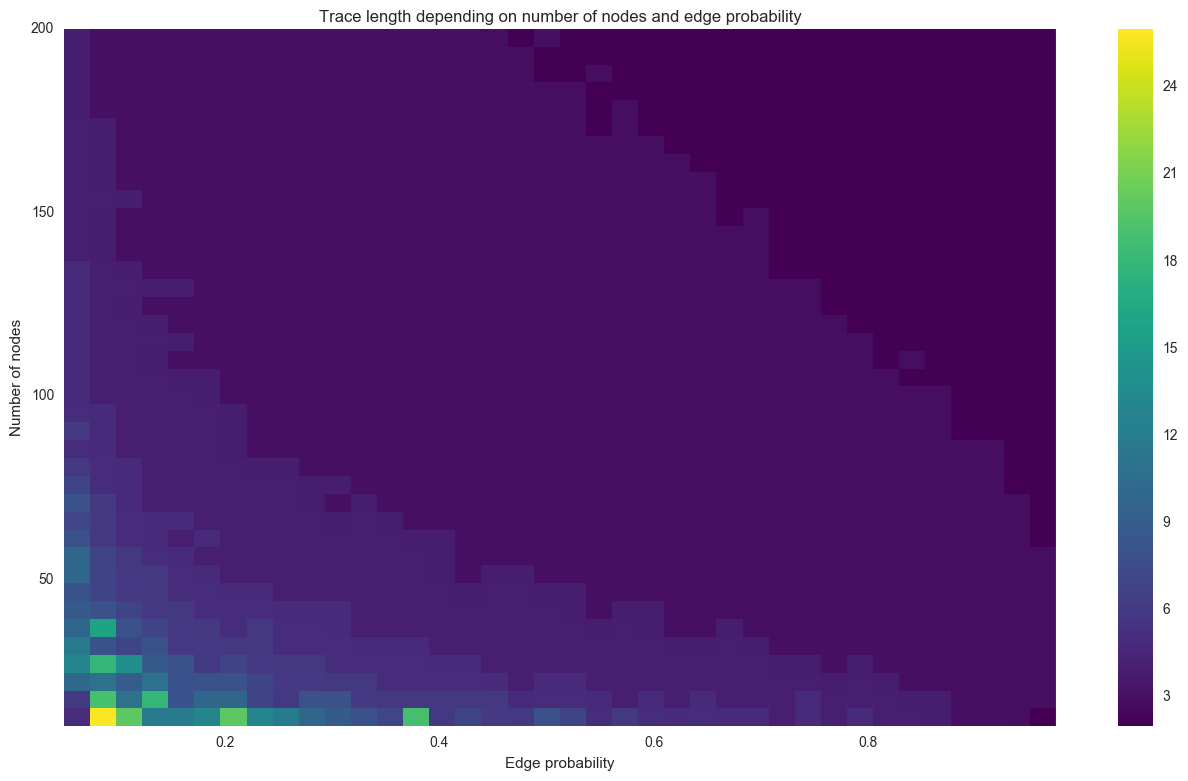

In [75]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.set_style({'axes.grid' : False})
traces_plot = ax.imshow(trace_lengths, cmap='viridis', aspect='auto', origin='lower',
                        extent=[np.min(ps), np.max(ps), np.min(ns), np.max(ns)],
                        interpolation='none')
fig.colorbar(traces_plot)
plt.xlabel('Edge probability')
plt.ylabel('Number of nodes')
plt.title('Trace length depending on number of nodes and edge probability')
plt.show()

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [7]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(url)
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            print('Found ' + str(urlunparse(link)))
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [51]:
urls = ['https://yandexdataschool.ru']
site = get_site(urls[0])
links = []

N = 500
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

Loaded https://yandexdataschool.ru
Found https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie
Found https://www.coursera.org/specializations/machine-learning-data-analysis
Found https://yandexdataschool.com
Found https://yandexdataschool.ru/about
Found https://yandexdataschool.ru/admission
Found https://yandexdataschool.ru/edu-process
Found https://yandexdataschool.com/conference
Found https://yandex.ru
Loaded https://yandexdataschool.ru/about
Found https://yandexdataschool.ru/
Found https://yandexdataschool.ru/about
Found https://yandexdataschool.ru/admission
Found https://yandexdataschool.ru/edu-process
Found https://yandexdataschool.com/conference
Found https://yandexdataschool.com
Found https://yandexdataschool.ru/about/administration
Found https://yandexdataschool.ru/about/branches
Found https://yandexdataschool.ru/about/collaborations
Found https://yandexdataschool.ru/about/graduates
Found https://yandexdataschool.ru/about/contacts
Found https://yandex.ru
Loaded https://ya

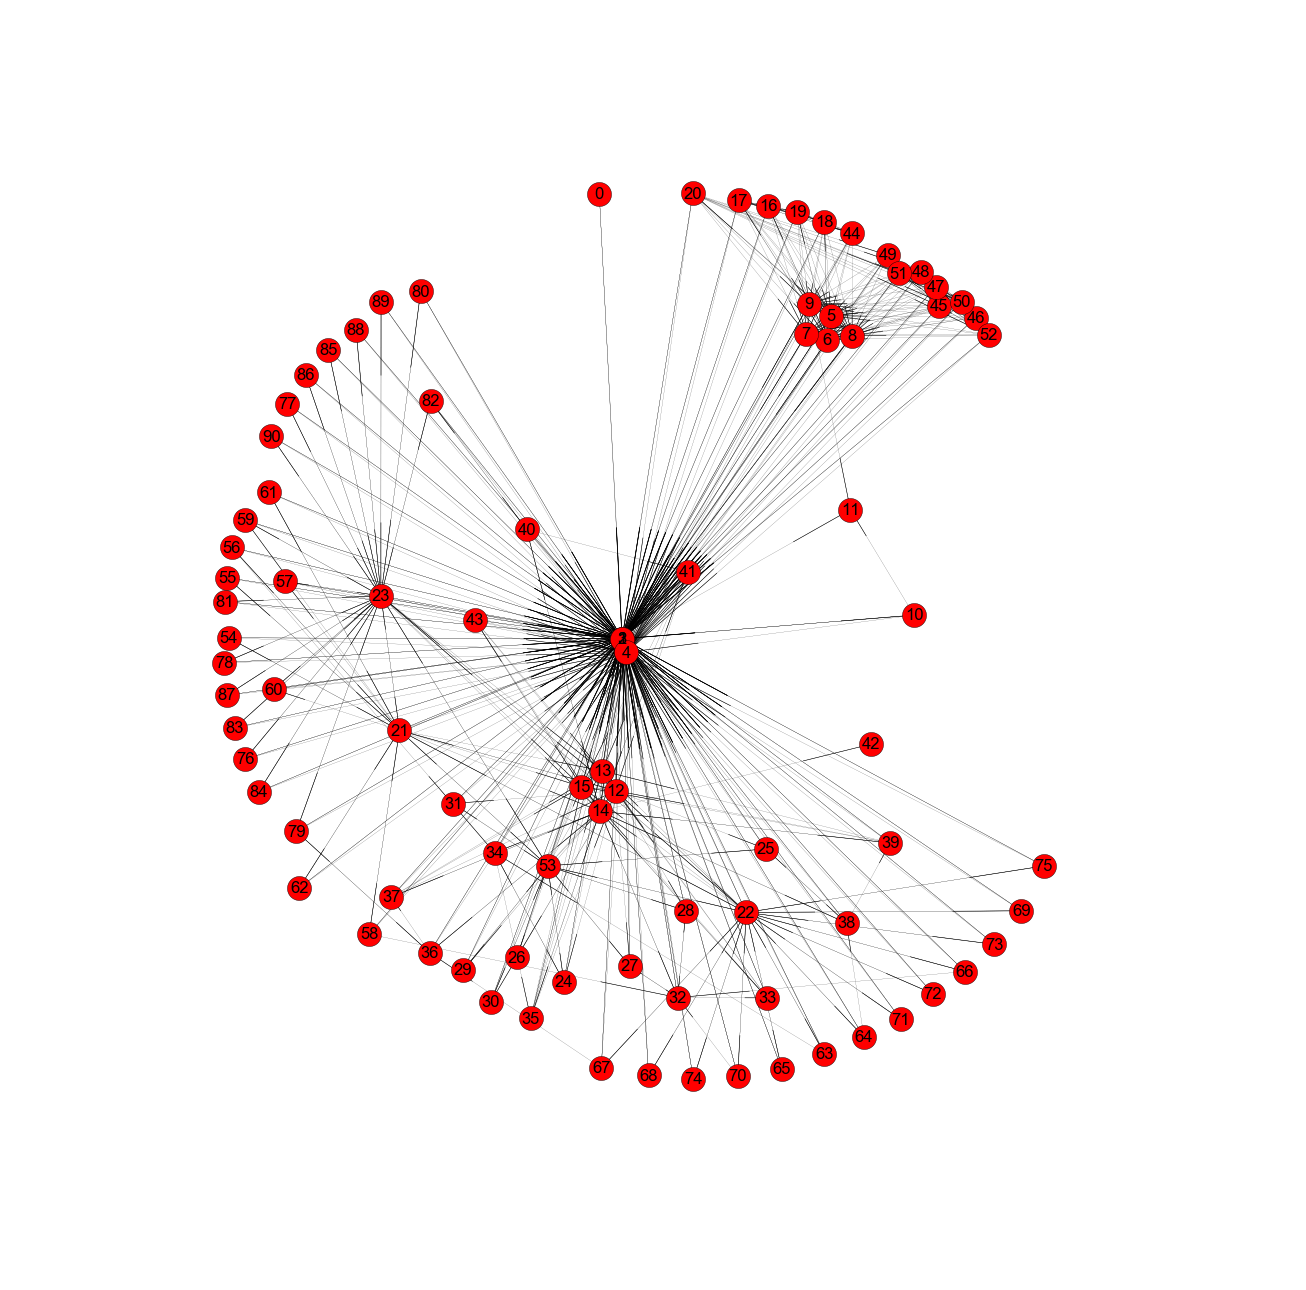

In [69]:
N = np.max(links) + 1
G = networkx.DiGraph()
# G.add_nodes_from()
G.add_nodes_from(range(N))
G.add_edges_from(links)
plt.figure(figsize=(16, 16))
plt.axis('off')
networkx.draw_networkx(G, width=0.1)

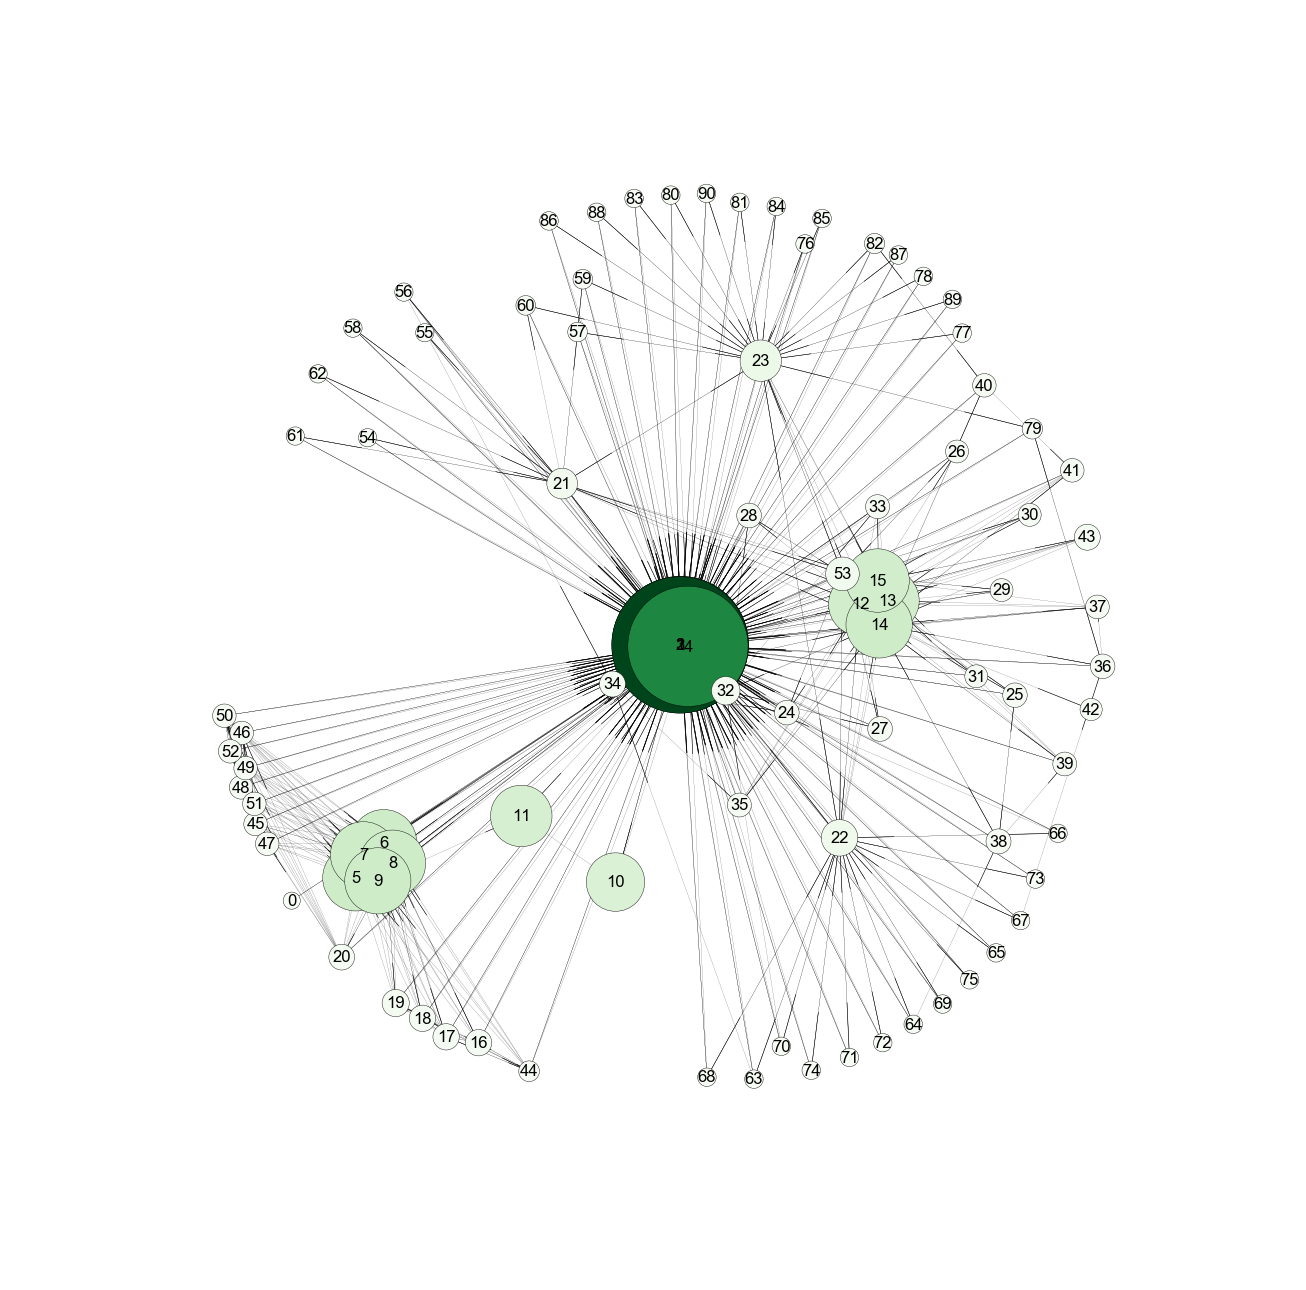

In [68]:
start_distribution = np.ones((1, N)) / N
pr_distribution, trace = page_rank(links, start_distribution, return_trace=True)

size_const = 8e4
plt.figure(figsize=(16, 16))
plt.axis('off')
networkx.draw_networkx(G, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution,cmap='Greens')

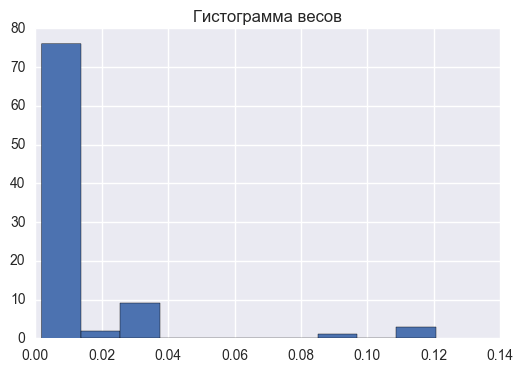

In [75]:
plt.title('Гистограмма весов')
plt.hist(pr_distribution)
plt.show()

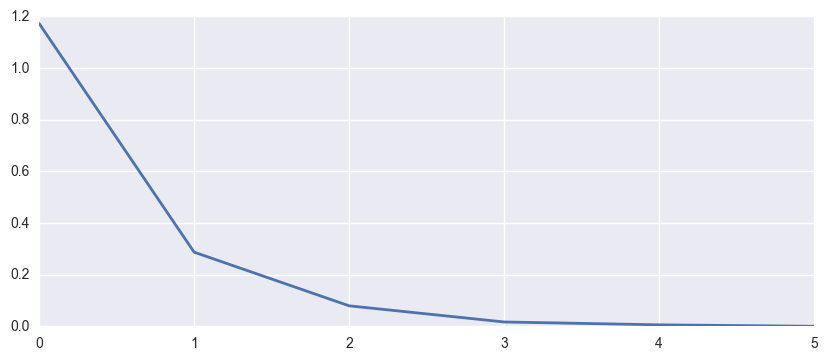

In [73]:
errors = np.abs(trace - trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2,)

Видно, что скорость сходимости экспоненциальная.

In [84]:
nodes = pr_distribution.argsort()[::-1][:20]

In [85]:
np.array(urls)[nodes]

array(['https://yandexdataschool.ru/about',
       'https://yandexdataschool.ru/admission',
       'https://yandexdataschool.ru/edu-process',
       'https://yandexdataschool.ru/',
       'https://yandexdataschool.ru/edu-process/courses',
       'https://yandexdataschool.ru/about/graduates',
       'https://yandexdataschool.ru/about/contacts',
       'https://yandexdataschool.ru/about/administration',
       'https://yandexdataschool.ru/about/branches',
       'https://yandexdataschool.ru/about/collaborations',
       'https://yandexdataschool.ru/edu-process/schedule',
       'https://yandexdataschool.ru/edu-process/program',
       'https://yandexdataschool.ru/edu-process/teachers',
       'mailto://yandexdataschool.ru/shad@yandex-team.ru',
       'https://yandexdataschool.ru/admission/faq',
       'https://yandexdataschool.ru/edu-process/program/special-courses',
       'https://yandexdataschool.ru/edu-process/program/big-data',
       'https://yandexdataschool.ru/edu-process/program

In [86]:
links_for_nodes = [link for link in links if link[0] in nodes and link[1] in nodes]

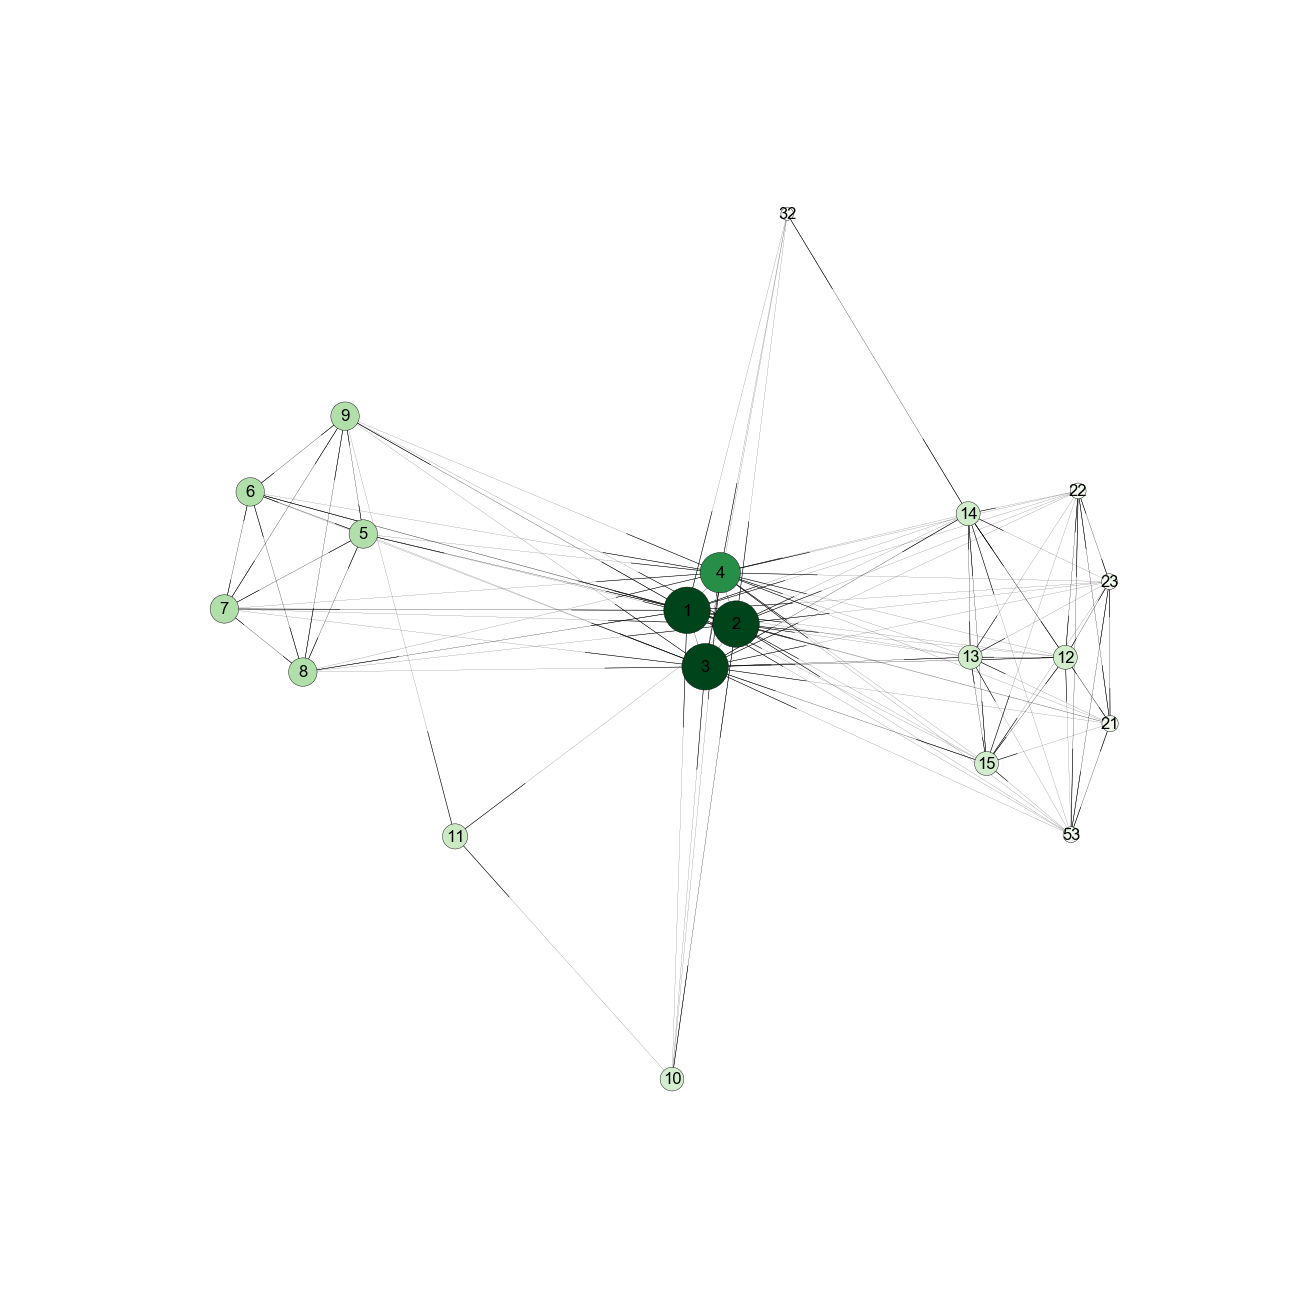

In [88]:
G_main = networkx.DiGraph()
N = len(nodes)
G_main.add_nodes_from(nodes)
G_main.add_edges_from(links_for_nodes)
start_distribution = np.ones((1, N)) / N
pr_distribution, trace = page_rank(links, start_distribution, return_trace=True)

size_const = 8e4
plt.figure(figsize=(16, 16))
plt.axis('off')
networkx.draw_networkx(G_main, width=0.1, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution,cmap='Greens')

In [90]:
print(np.array(urls)[nodes])

['https://yandexdataschool.ru/about'
 'https://yandexdataschool.ru/admission'
 'https://yandexdataschool.ru/edu-process' 'https://yandexdataschool.ru/'
 'https://yandexdataschool.ru/edu-process/courses'
 'https://yandexdataschool.ru/about/graduates'
 'https://yandexdataschool.ru/about/contacts'
 'https://yandexdataschool.ru/about/administration'
 'https://yandexdataschool.ru/about/branches'
 'https://yandexdataschool.ru/about/collaborations'
 'https://yandexdataschool.ru/edu-process/schedule'
 'https://yandexdataschool.ru/edu-process/program'
 'https://yandexdataschool.ru/edu-process/teachers'
 'mailto://yandexdataschool.ru/shad@yandex-team.ru'
 'https://yandexdataschool.ru/admission/faq'
 'https://yandexdataschool.ru/edu-process/program/special-courses'
 'https://yandexdataschool.ru/edu-process/program/big-data'
 'https://yandexdataschool.ru/edu-process/program/computer-science'
 'https://yandexdataschool.ru/edu-process/program/data-analysis'
 'https://yandexdataschool.ru/edu-process/

Наверное, эти страницы имеют большой вес, поскольку содержат основную информацию о ШАДе.

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [28]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            relevance_and_features, query_id = line.split(' # ')
            split_line = relevance_and_features.split(' ')
            # релевантность и id запроса
            relevs.append(float(split_line[0]))
            qids.append(int(query_id))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:]:
                index, value = feat.split(':')
                index = int(index)
                value = float(value)
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)


def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')
            

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

In [68]:
def read_metric_dependence_from_file(file_name, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        end = text.index("Finished sucessfully.\n", index) - 1
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:end])))
        values.append(block_values)
        text = text[index:]
        
    return values

In [30]:
relevs, qids, features = read_file('./imat2009-datasets/imat2009_learning.txt', 250)

In [32]:
split_to_train_valid_test(relevs, qids, features,
                          './train.txt', './test.txt', 0.1, 0.1, 
                          valid_path='./valid.txt', valid_size=0.1)

MART

In [47]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./train.txt -test ./test.txt -validate ./valid.txt -ranker 0 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./MART.txt > ./log_MART.txt

CPU times: user 322 ms, sys: 89.1 ms, total: 411 ms
Wall time: 30.3 s


LambdaMART

In [49]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./train.txt -test ./test.txt -validate ./valid.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./LambdaMART.txt > ./log_LambdaMART.txt

CPU times: user 363 ms, sys: 94.8 ms, total: 457 ms
Wall time: 33.2 s


Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

In [59]:
sns.set_style({'axes.grid' : True})

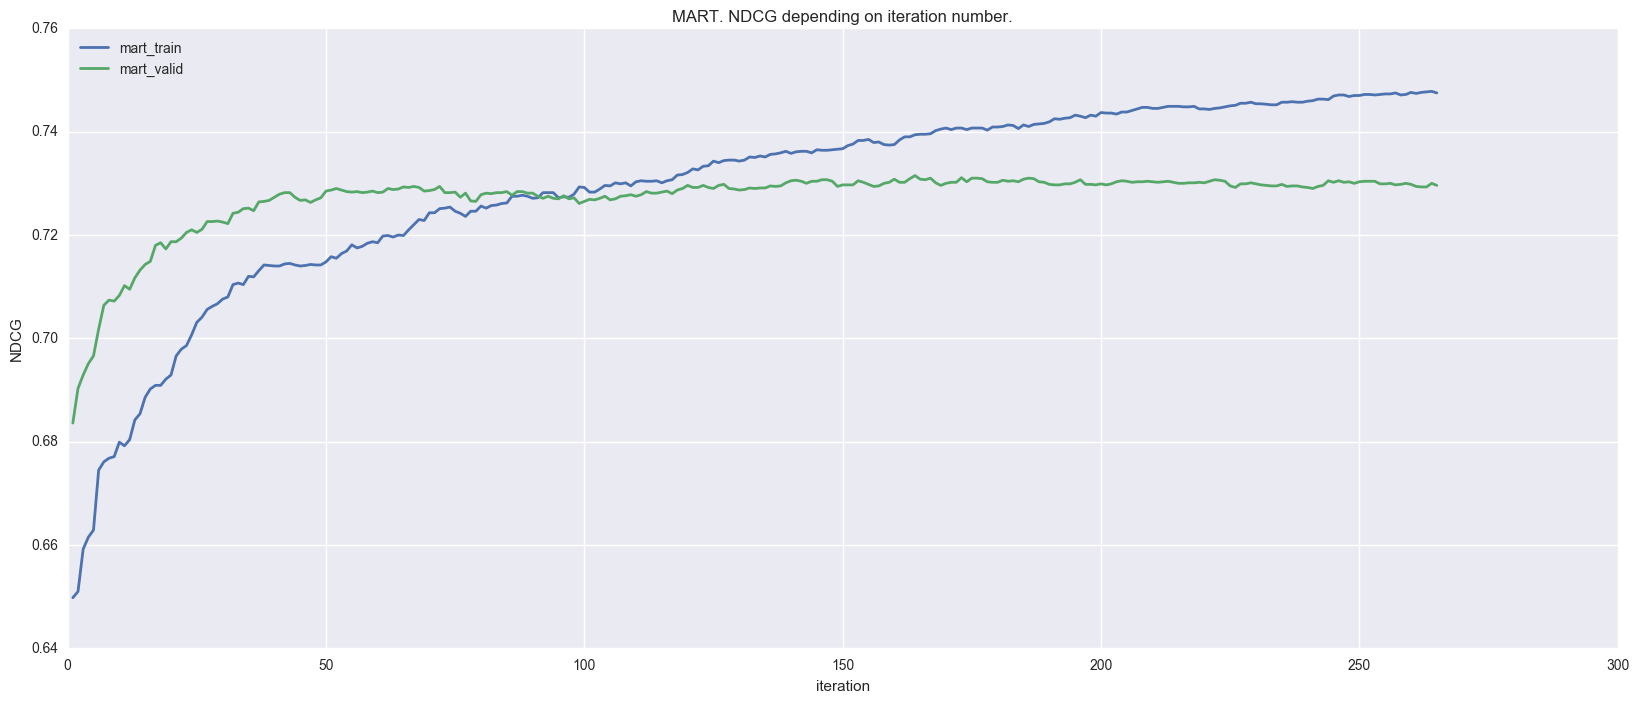

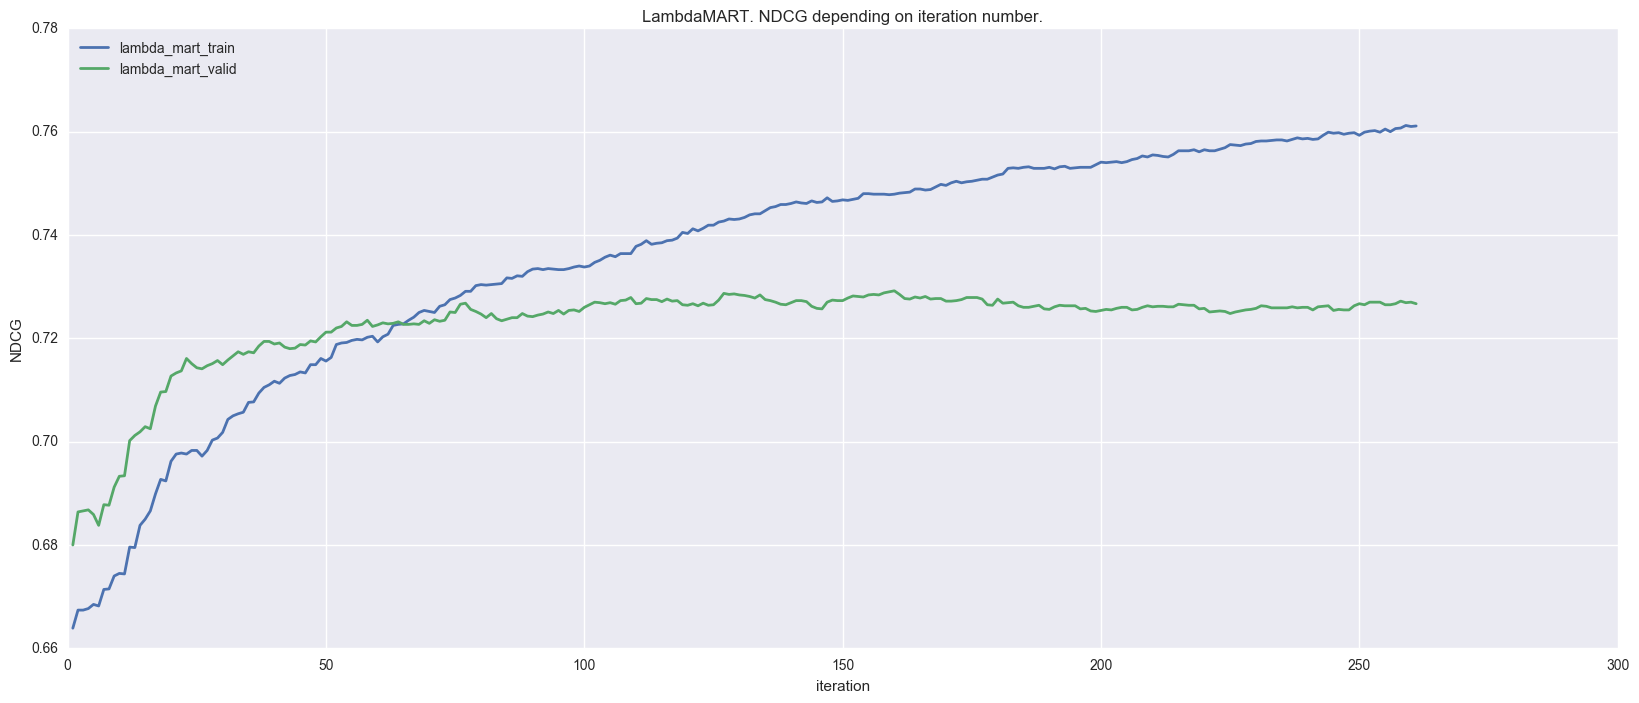

In [69]:
values_lambda_mart = np.vstack(read_metric_dependence_from_file('log_LambdaMART.txt'))
values_mart = np.vstack(read_metric_dependence_from_file('log_MART.txt'))
# print(values_mart)
plt.figure(figsize=(20, 8))
plt.plot(values_mart[:, 0], values_mart[:, 1], lw=2, label='mart_train')
plt.plot(values_mart[:, 0], values_mart[:, 2], lw=2, label='mart_valid')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('MART. NDCG depending on iteration number.')
plt.legend(loc=2)
plt.figure(figsize=(20, 8))
plt.plot(values_lambda_mart[:, 0], values_lambda_mart[:, 1], lw=2, label='lambda_mart_train')
plt.plot(values_lambda_mart[:, 0], values_lambda_mart[:, 2], lw=2, label='lambda_mart_valid')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('LambdaMART. NDCG depending on iteration number.')
plt.legend(loc=2)
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

Нельзя сказать, что какая-то из моделей работает сильно лучше. Точка переобучения достигается (линии для train и test пересеклись).

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

RankNet

In [65]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./train.txt -test ./test.txt -validate ./valid.txt -ranker 1 -metric2t NDCG@10 -save ./RankNet.txt > ./log_RankNet.txt

CPU times: user 1.51 s, sys: 366 ms, total: 1.88 s
Wall time: 2min 25s


RandomForest

In [66]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./train.txt -test ./test.txt -validate ./valid.txt -ranker 8 -metric2t NDCG@10 -save ./RandomForest.txt > ./log_RandomForest.txt

CPU times: user 2.51 s, sys: 592 ms, total: 3.11 s
Wall time: 3min 28s


График для RandomForest не получится построить, поскольку логи для него имеют другой формат и в них нет значений метрики на valid-е.

Еще, автор задания предлагает воспользоваться его функциями для парсинга логов, которые также не учитывают этого факта и в большинстве других случаев также не работают.

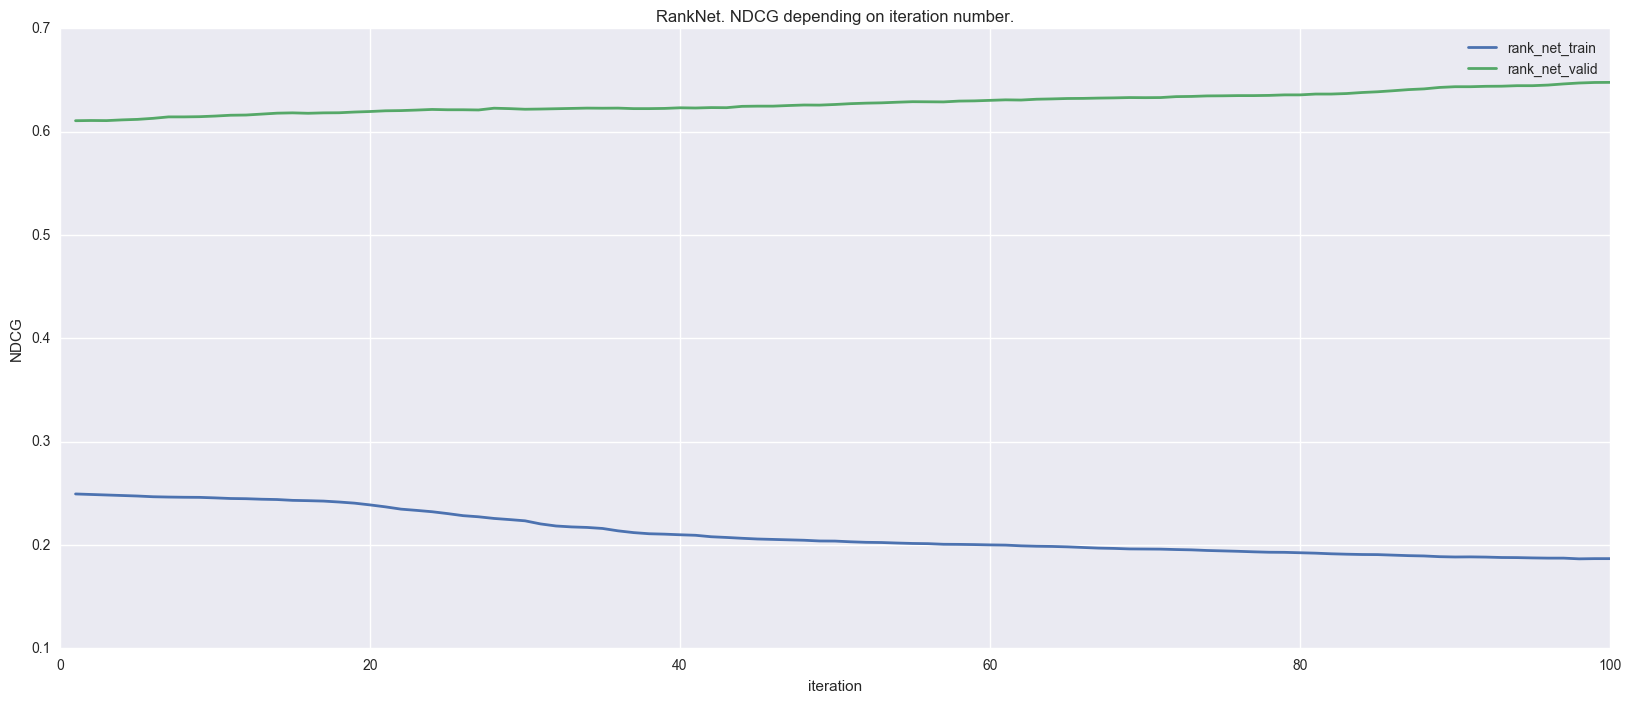

In [77]:
values_rank_net = np.vstack(list(read_metric_dependence_from_file('log_RankNet.txt')[0][1:]))
plt.figure(figsize=(20, 8))
plt.plot(values_rank_net[:, 0], values_rank_net[:, 1], lw=2, label='rank_net_train')
plt.plot(values_rank_net[:, 0], values_rank_net[:, 2], lw=2, label='rank_net_valid')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('RankNet. NDCG depending on iteration number.')
plt.legend()
plt.show()

Результаты для RandomForest:

NDCG@10 on training data: 0.7756

NDCG@10 on validation data: 0.7342

Видно, что RankNet не переобучается, но работает хуже LambdaMART и MART.
Насчет переобучения RandomForest ничего сказать нельзя, по описанным выше причинам. Но работает он примерно также как LambdaMART и MART

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ>

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [78]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

0.0

0.4804530139182014

1.206948960812582

1.9218120556728056

2.5902903939802346



In [98]:
def shuffle(relevs, qids, features):
    query_dict = defaultdict(lambda: ([], []))
    for relevance, query_id, feature in zip(relevs, qids, features):
        query_dict[query_id][0].append(relevance)
        query_dict[query_id][1].append(feature)
    qids = list(set(qids))
    np.random.shuffle(qids)
    new_relevs, new_qids, new_features = [], [], []
    for query_id in qids:
        new_qids.extend([query_id] * len(query_dict[query_id][0]))
        new_relevs.extend(query_dict[query_id][0])
        new_features.extend(query_dict[query_id][1])
    return new_relevs, new_qids, np.array(new_features)

In [99]:
def read_volkov_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:]:
                index, value = map(float, feat.split(':'))
                if index < features_count:
                    object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

In [117]:
M = 10
! rm -f 'LambdaMART_cumulative.txt'; touch 'LambdaMART_cumulative.txt'

In [ ]:
all_results = []
for iter_num in range(M):
    ! rm -f 'LambdaMART_cumulative.txt'; touch 'LambdaMART_cumulative.txt'
    relevs, qids, features = shuffle(*read_volkov_file('./train.txt', 250))
    write(features, relevs, qids, './train_1.txt', 0, int(len(features) / 2))
    write(features, relevs, qids, './train_2.txt', int(len(features) / 2), len(features))
    ! java -jar RankLib-2.1-patched.jar -train ./train_1.txt -test ./test.txt -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 -save ./LambdaMART{iter_num}.txt > ./log_LambdaMART{iter_num}.txt
    with open('./LambdaMART{}.txt'.format(iter_num)) as model:
        model_text = model.readlines()
        model_header, model_xml = model_text[:7], model_text[7:]
        soup = BeautifulSoup('\n'.join(model_xml), 'lxml')
        tree_tags = soup.find_all('tree')
    k_model_results = []
    for k in range(1, 301):
        with open('LambdaMART_cumulative.txt', 'r+') as k_model:
            k_model_text = k_model.readlines()
            k_model_header, k_model_xml = k_model_text[:7], k_model_text[7:]
            if k == 1:
                k_model_header = model_header
                k_model_header[1] = '## No. of trees = {}\n'.format(1)
                k_model_xml = ['<ensemble>\n', str(tree_tags[0]), '</ensemble>\n']
            else:
                model_header[1] = '## No. of trees = {}\n'.format(k)
                k_model_xml.append(str(tree_tags[k-1]))
                ensemble_end = k_model_xml[-2]
                k_model_xml[-2] = k_model_xml[-1]
                k_model_xml[-1] = ensemble_end
        with open('LambdaMART_cumulative.txt', 'w') as k_model:
            k_model.write('\n'.join(k_model_header))
            k_model.write('\n'.join(k_model_xml))
        ! java -jar RankLib-2.1-patched.jar -load ./LambdaMART_cumulative.txt -test ./test.txt -metric2T NDCG@10 > result.txt
        with open('result.txt') as res:
            res_text = res.readlines()
            ndcg = float(res_text[-1].split(': ')[1])
            k_model_results.append(ndcg)
    all_results.append(k_model_results)

In [ ]:
all_results = np.array(all_results)
plt.plot(np.average(all_results, axis=0)